# Distributed Genex
This notebook implements redistributed Genex for faster and more reliable processing.

## Get the input list
Use the generate_source call from genex.preprocess to get our input list, which is a key-value pair with key being the
features of the time series and the value is time series itself, or, the raw data.

For now, we only take the first 50 time series to speed it up.

In [1]:
import math
from genex.parse import generate_source
fn = 'SART2018_HbO.csv'

input_list = generate_source(fn, feature_num=5)
input_list = input_list[:24]

# print the keys of the  input_list
for time_series in input_list: print(time_series[0])

('101-SART-June2018-AS', 'target correct', 'Channel-1 HbO', '126468', '167986')
('101-SART-June2018-AS', 'target correct', 'Channel-1 HbO', '274131', '315653')
('101-SART-June2018-AS', 'target correct', 'Channel-1 HbO', '403678', '445179')
('101-SART-June2018-AS', 'target correct', 'Channel-1 HbO', '600024', '641559')
('101-SART-June2018-AS', 'target correct', 'Channel-1 HbO', '624914', '666433')
('101-SART-June2018-AS', 'target correct', 'Channel-1 HbO', '631505', '673041')
('101-SART-June2018-AS', 'target correct', 'Channel-1 HbO', '667507', '709026')
('101-SART-June2018-AS', 'target correct', 'Channel-1 HbO', '777318', '818835')
('101-SART-June2018-AS', 'target correct', 'Channel-1 HbO', '789029', '830533')
('101-SART-June2018-AS', 'target correct', 'Channel-1 HbO', '794000', '835502')
('101-SART-June2018-AS', 'target correct', 'Channel-1 HbO', '836659', '878161')
('101-SART-June2018-AS', 'target correct', 'Channel-1 HbO', '854762', '896297')
('101-SART-June2018-AS', 'target correct

## Normalization
Globally min-max normalize the input-list

In [2]:
from genex.preprocess import min_max_normalize
normalized_input_list, global_max, global_min = min_max_normalize(input_list)

## Configure Spark
Create the spark context with which the input_list will be processed, setting the number of CPU (cores), driver memory
and max result size. Those configurations depends on the specs on the cluster.

In [3]:
from pyspark import SparkContext, SparkConf

num_cores = 12

conf = SparkConf(). \
    setMaster("local[" + str(num_cores) + "]"). \
    setAppName("Genex").set('spark.driver.memory', '31G'). \
    set('spark.driver.maxResultSize', '31G')
sc = SparkContext(conf=conf)

## Distribute the normalized input list
distribute the input list onto the works, each worker will have two partitions

In [4]:
input_rdd = sc.parallelize(normalized_input_list, numSlices= num_cores)
partition_input = input_rdd.glom().collect()

# Cluster
## Grouping the data
We group the time series on each worker. Setting loi to be 5 so to 
ignore sequences with a length less than 120.

In [5]:
from genex.preprocess import all_sublists_with_id_length
group_rdd = input_rdd.flatMap(
    lambda x: all_sublists_with_id_length(x, [120]))
partition_group = group_rdd.glom().collect()

## Cluster the data with Gcluster
Now the time series on each core has been broken down into subsequence. We will proceed
with node-wise clustering with the Genex algorithm.

Note that this implementation uses a different clustering than the previous implementation.

At the end of the operation, we cache the result so that once computed, the cluster_rbb would be retained in the pre-set


In [6]:
from genex.cluster import filter_cluster

cluster_rdd = group_rdd.mapPartitions(lambda x: filter_cluster(groups=x, st=0.05, log_level=1), preservesPartitioning=False).cache()
cluster_partition = cluster_rdd.glom().collect()

## Visualize the result
Plot one of the clusters. We plot 


In [7]:
import matplotlib.pyplot as plt 
partition_num = 10
length_of_clusterSeq = 120

cluster_to_plot = dict(cluster_partition[partition_num])[120]

print('Plotting cluster of length ' + str(length_of_clusterSeq) + ' from Partition ' + str(partition_num))

for repr, repr_cluster in cluster_to_plot.items():
    # plot the sequences represented
    for seq in repr_cluster:
        plt.plot(seq.fetch_data(input_list), color = 'b')
        # plot the representative
    plt.plot(repr.fetch_data(input_list), color='r', linewidth=3.0)
    plt.show()

Plotting cluster of length 120 from Partition 10


<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

# Query
## Generate the query sequence
Parse the query sequence from the input file

(101-SART-June2018-AS)_(target-correct)_(Channel-1-HbO)_(126468)_(167986): (0:274)


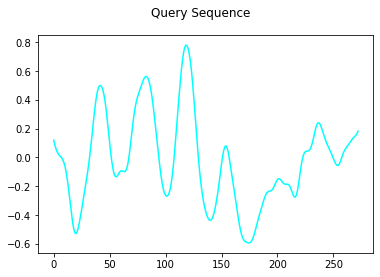

In [8]:
from genex.parse import generate_query
import random

# generate the query sets
query_set = generate_query(file_name='queries.csv', feature_num=5)
# randomly pick a sequence as the query from the query sequence, make sure the picked sequence is in the input list
query = next((item for item in query_set if item.id in dict(input_list).keys()), None)
# fetch the data for the query
query.set_data(query.fetch_data(input_list))

print(query)
fig = plt.figure()
plt.plot(query.data, color='cyan')
fig.suptitle('Query Sequence')
plt.show()

## Normalize the query
Normalize the query data with the same scale as when normalizing the input data. Then broadcast it onto the executors

(101-SART-June2018-AS)_(target-correct)_(Channel-1-HbO)_(126468)_(167986): (0:274)


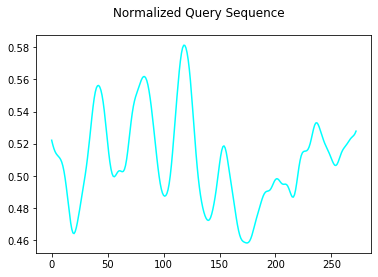

In [9]:
from genex.utils import normalize_sequence

normalize_sequence(query, global_max, global_min)
query_bc = sc.broadcast(query)

print(query)
fig = plt.figure()
plt.plot(query.data, color='cyan')
fig.suptitle('Normalized Query Sequence')
plt.show()

## Define the function to process cluster partition

In [10]:
import heapq
import time
from genex.cluster import sim_between_seq

query_st = math.inf
best_k = 5

def query_cluster_partition(cluster, q, st: float, k: int, normalized_input, dist_type: str = 'eu', loi=None):
    q = q.value
    normalized_input = normalized_input.value
    
    if loi is not None:
        cluster_dict = dict(x for x in cluster if x[0] in range(loi[0], loi[1]))
    else:
        cluster_dict = dict(cluster)
    # get the seq length of the query, start query in the cluster that has the same length as the query
    
    querying_clusterSeq_len = len(q)

    # get the seq length Range of the partition
    try:
        len_range = (min(cluster_dict.keys()), max(cluster_dict.keys()))
    except ValueError as ve:
        raise Exception('cluster does not have the given query loi!')
        
        
    # if given query is longer than the longest cluster sequence,
    # set starting clusterSeq length to be of the same length as the longest sequence in the partition
    querying_clusterSeq_len = max(min(querying_clusterSeq_len, len_range[1]), len_range[0])

    query_result = []
    # temperoray variable that decides whether to look up or down when a cluster of a specific length is exhausted

    while len(cluster_dict) > 0:
        target_cluster = cluster_dict[querying_clusterSeq_len]
        target_cluster_reprs = target_cluster.keys()
        target_cluster_reprs = list(
            map(lambda rpr: [sim_between_seq(rpr.fetch_data(normalized_input), q.data, dist_type=dist_type), rpr], target_cluster_reprs))
        # add a counter to avoid comparing a Sequence object with another Sequence object
        heapq.heapify(target_cluster_reprs)

        while len(target_cluster_reprs) > 0:
            querying_repr = heapq.heappop(target_cluster_reprs)
            querying_cluster = target_cluster[querying_repr[1]]
            querying_cluster = list(
                map(lambda cluster_seq: [sim_between_seq(cluster_seq.fetch_data(normalized_input), q.data, dist_type=dist_type), cluster_seq],
                    querying_cluster))
            heapq.heapify(querying_cluster)

            for seq in querying_cluster:
                if seq[0] < st:
                    query_result.append((seq[0], seq[1]))
                    if(len(query_result)) >= k:
                        return query_result

        cluster_dict.pop(querying_clusterSeq_len)  # remove this len-cluster just queried

        # find the next closest sequence length
        querying_clusterSeq_len = min(list(cluster_dict.keys()), key=lambda x: abs(x - querying_clusterSeq_len))

    return query_result

normalized_input_list_bc = sc.broadcast(normalized_input_list)
query_bc = sc.broadcast(query)

# a = query_cluster_partition(cluster=cluster_partition[0], q=query_bc, st=query_st, k=best_k,
#                             normalized_input=normalized_input_list_bc, loi=[150, 160])

query_rdd = cluster_rdd.mapPartitions(
    lambda x: 
    query_cluster_partition(cluster=x, q=query_bc, st=query_st, k=best_k, 
                            normalized_input=normalized_input_list_bc, loi=[150, 160])).cache()
query_partition = query_rdd.glom().collect()

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 3.0 failed 1 times, most recent failure: Lost task 0.0 in stage 3.0 (TID 36, localhost, executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/Users/Leo/PycharmProjects/Genex/venv/lib/python3.6/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 377, in main
    process()
  File "/Users/Leo/PycharmProjects/Genex/venv/lib/python3.6/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 372, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/Users/Leo/PycharmProjects/Genex/venv/lib/python3.6/site-packages/pyspark/rdd.py", line 352, in func
    return f(iterator)
  File "<ipython-input-10-b500091f1771>", line 72, in <lambda>
  File "<ipython-input-10-b500091f1771>", line 44, in query_cluster_partition
KeyError: 1566842618.723857

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:452)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:588)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:571)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:406)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at org.apache.spark.storage.memory.MemoryStore.putIterator(MemoryStore.scala:221)
	at org.apache.spark.storage.memory.MemoryStore.putIteratorAsBytes(MemoryStore.scala:349)
	at org.apache.spark.storage.BlockManager$$anonfun$doPutIterator$1.apply(BlockManager.scala:1182)
	at org.apache.spark.storage.BlockManager$$anonfun$doPutIterator$1.apply(BlockManager.scala:1156)
	at org.apache.spark.storage.BlockManager.doPut(BlockManager.scala:1091)
	at org.apache.spark.storage.BlockManager.doPutIterator(BlockManager.scala:1156)
	at org.apache.spark.storage.BlockManager.getOrElseUpdate(BlockManager.scala:882)
	at org.apache.spark.rdd.RDD.getOrCompute(RDD.scala:335)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:286)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:65)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:121)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1889)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1877)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1876)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1876)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2110)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2059)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2048)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:737)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2061)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2082)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2101)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2126)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:945)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:944)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:166)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/Users/Leo/PycharmProjects/Genex/venv/lib/python3.6/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 377, in main
    process()
  File "/Users/Leo/PycharmProjects/Genex/venv/lib/python3.6/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 372, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/Users/Leo/PycharmProjects/Genex/venv/lib/python3.6/site-packages/pyspark/rdd.py", line 352, in func
    return f(iterator)
  File "<ipython-input-10-b500091f1771>", line 72, in <lambda>
  File "<ipython-input-10-b500091f1771>", line 44, in query_cluster_partition
KeyError: 1566842618.723857

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:452)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:588)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:571)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:406)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at org.apache.spark.storage.memory.MemoryStore.putIterator(MemoryStore.scala:221)
	at org.apache.spark.storage.memory.MemoryStore.putIteratorAsBytes(MemoryStore.scala:349)
	at org.apache.spark.storage.BlockManager$$anonfun$doPutIterator$1.apply(BlockManager.scala:1182)
	at org.apache.spark.storage.BlockManager$$anonfun$doPutIterator$1.apply(BlockManager.scala:1156)
	at org.apache.spark.storage.BlockManager.doPut(BlockManager.scala:1091)
	at org.apache.spark.storage.BlockManager.doPutIterator(BlockManager.scala:1156)
	at org.apache.spark.storage.BlockManager.getOrElseUpdate(BlockManager.scala:882)
	at org.apache.spark.rdd.RDD.getOrCompute(RDD.scala:335)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:286)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:65)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:121)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


## Visualize the query result

In [ ]:
for i, q_partition in enumerate(query_partition):
    fig = plt.figure()
    fig.set_size_inches(10.5, 10.5)
    fig.suptitle('Query result from Partition #' + str(i))

    for distance, seq in q_partition:
        plt.plot(seq.fetch_data(input_list), label="{:.3f}".format(distance))
        
    plt.plot(query.fetch_data(input_list), color='cyan', linewidth=3.0, label='Query Sequence')
    plt.legend()
    plt.show()

## Sort the aggregated query results
Sort the returned query results from the 

In [ ]:
aggre_query_result = query_rdd.collect()
heapq.heapify(aggre_query_result)
best_matches = []

for i in range(best_k):
    best_matches.append(heapq.heappop(aggre_query_result)) 

Plot the final best matches

In [ ]:
fig = plt.figure()
plt.plot(query.fetch_data(input_list), color='cyan', linewidth=3.0, label='Query Sequence')
for seq in best_matches:
    plt.plot(seq[1].fetch_data(input_list), label="{:.3f}".format(seq[0]))
plt.legend()
plt.show()

# Issues
Query may run unbalanced cross executors

In [ ]:
# import pickle
# 
# cluster_result = cluster_rdd.collect()
# pickle.dump(cluster_result, open('results/cluster_result.p', 'wb'))
# cluster_rdd.saveAsTextFile('results/cluster_rdd.p')
# 
# print('done')

In [ ]:
# cluster_rdd_reloaded = sc.textFile('results/cluster_rdd.p')
# cluster_result_reloaded = cluster_rdd_reloaded.collect()